In [4]:
import requests as r
from datetime import datetime, timedelta
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import seaborn as sns

# Apply the default theme and color scheme
sns.set_theme()
sns.set_style('dark')
sns.set_color_codes(palette='bright')

/Users/jonathantalmi/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/jonathantalmi/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [7]:
key = 'b432689fb54a467b81080b13731b9795'

start_date = '1980-02-01'
end_date = '2021-03-01'
url = 'https://api.oikolab.com/weather?'

# set params for dallas, texas
params = dict(
  lat=32.7767,
  lon=-96.7970,
  param='temperature',
  freq='H',
  start=start_date,
  end=end_date
)
params['api-key'] = key

In [10]:
def fetch_data(params, freq):
    params['freq'] = freq
    res = r.get(url, params=params)
    print(res)
    data = res.json()
    df = pd.DataFrame(
        data=json.loads(data['data'])['data'],
        index=pd.to_datetime(json.loads(data['data'])['index'], unit='s', origin='unix'),
        columns=['temp']
    )
    display(HTML(df.tail().to_html()))
    df['2020-01-01':].plot(y='temp', use_index=True)
    return df

def generate_viz(df):
    # format data for viz
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    grouped_df = df[(df.month == 2)&(df.year != 2021)].groupby(['hour', 'day', 'month']).agg(['min', 'max', 'mean', 'median'])['temp']
    grouped_df = grouped_df.reset_index()
    grouped_df = grouped_df.sort_values(['day', 'hour'])

    # generate viz
    max_intervals = df[(df.year == 1984)&(df.month==2)].shape[0]
    daily_intervals = df[(df.year == 1984)&(df.month==2)&(df.day==1)].shape[0]
    plt.figure(figsize=(16,9)) 
    plt.plot(np.arange(len(grouped_df['max'])),grouped_df['max'], '--k', label="pre-2021 record high")
    plt.plot(np.arange(len(grouped_df['max'])),grouped_df['min'], '-k',label="pre-2021 record low")
    df_2021 = df[(df.year == 2021)&(df.month == 2)][['temp', 'hour']]
    plt.scatter(np.arange(len(df_2021['temp'])),
                df_2021['temp'], s=12, c='r',label='2021')
    plt.xlabel('day',size=18)
    plt.ylabel('temperature($^\circ C$ )',size=18)
    plt.xticks(
        np.arange(0, max_intervals, daily_intervals),
        [f'Feb. {i+1}' for i in range(29)],
        rotation=45)

    ax=plt.gca()
    ax.axis([0,max_intervals,-40,40])
    plt.gca().fill_between(np.arange(0,max_intervals), 
                           grouped_df['min'], grouped_df['max'], 
                           facecolor='skyblue', 
                           alpha=0.25)
    plt.title('Hourly temperatures in Dallas, Texas during February (1981-2021)',size=18)
    plt.legend(loc='upper left')
    plt.show()

<Response [200]>


,temp
2021-02-28 20:00:00,14.22
2021-02-28 21:00:00,13.55
2021-02-28 22:00:00,13.01
2021-02-28 23:00:00,12.40
2021-03-01 00:00:00,11.66


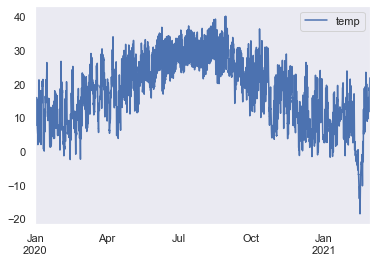

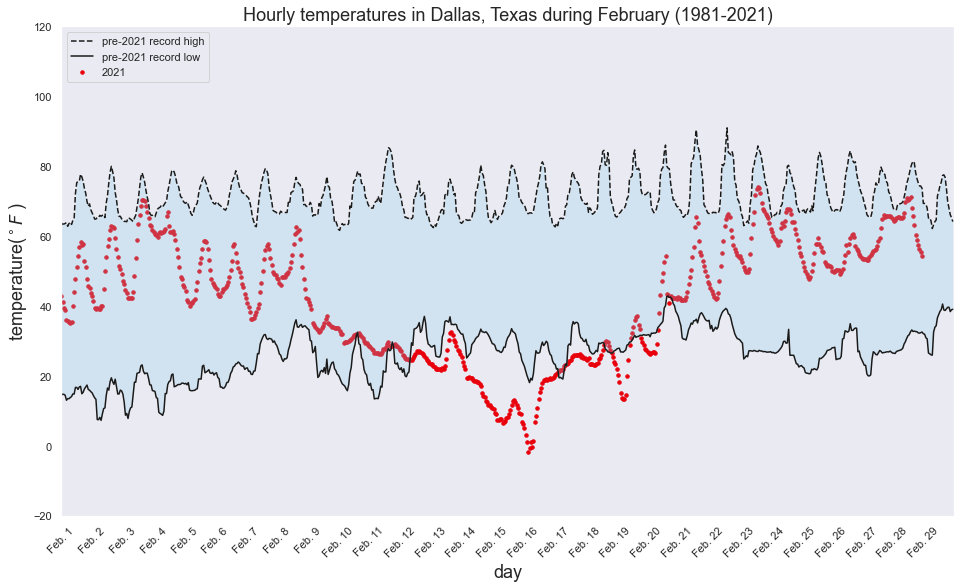

In [11]:
# Viz for Dallas
hourly_df = fetch_data(params, 'H')
generate_viz(hourly_df)